In [1]:
import pandas as pd
import os
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dropout, Dense, Activation
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

#import keras.backend.tensorflow_backend as KTF
#import tensorflow as tf

Using TensorFlow backend.


In [2]:
train_src_dir = "./data/train"
train_subclass_dir = "./processed/train"
val_subclass_dir = "./processed/validation"
log_dir = "./log"

img_height, img_width = 32, 32
batch_size = 32

samples_per_epoch = 45000
nb_epoch =300
nb_val_samples = 5000

change_lr_epoch = 100
start_lr = 0.01


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True)
                                  
val_datagen = ImageDataGenerator(rescale=1.0/255)                             
                                  


train_generator = train_datagen.flow_from_directory(train_subclass_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   class_mode="categorical")

validation_generator = val_datagen.flow_from_directory(val_subclass_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=batch_size,
                                                      class_mode="categorical")

Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


## Fine tuning VGG16 

In [3]:
def lr_scheduler(epoch, start_lr):
    quotient = int(epoch//change_lr_epoch)
    return float(start_lr/(10**quotient))
    


def fine_tuning_vgg16(model_name, train_gen, validation_gen, samples_per_epoch, nb_epoch, nb_val_samples):
    
    if os.path.exists("./model/{}_history.csv".format(model_name)):
        hist = pd.read_csv("./model/{}_history.csv".format(model_name))
        model = model_from_json(open("./model/{}_architecture.json".format(model_name)).read())
        model.load_weights("./model/{}_weights.h5".format(model_name))
        return model, hist
    
    else:         
        # Load VGG16 model and its weights
        input_tensor = Input(shape=(img_height, img_width, 3))
        vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_tensor)

        # Build fully connected layer
        top_model = Sequential()
        top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
        top_model.add(Dropout(0.5))
        top_model.add(Dense(1024, init="he_normal"))
        top_model.add(Activation("relu"))
        top_model.add(BatchNormalization())
        top_model.add(Dropout(0.5))
        top_model.add(Dense(1024, init="he_normal"))
        top_model.add(Activation("relu"))
        top_model.add(BatchNormalization())        
        top_model.add(Dense(10, init="glorot_normal"))
        top_model.add(Activation("softmax"))

        # Connect VGG16 to fully connected layer
        model = Model(input=vgg16.input, output=top_model(vgg16.output)) ###

        for layer in model.layers[: 15]:
            layer.trainable = False


        sgd = SGD(lr=start_lr,
                 momentum=0.9,
                 nesterov=True)

        early_stop = EarlyStopping(patience=30)
        #reduce_lr = ReduceLROnPlateau(monitor="val_loss")
        change_lr = LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr))


        model.compile(loss="categorical_crossentropy",
                     optimizer=sgd,
                     metrics=["accuracy"])


        history = model.fit_generator(train_gen,
                                     samples_per_epoch=samples_per_epoch,
                                     nb_epoch=nb_epoch,
                                     validation_data=validation_gen,
                                     verbose=2,
                                     nb_val_samples=nb_val_samples,
                                     callbacks=[early_stop, change_lr])

        if not os.path.exists("./model"):
            os.mkdir("./model")

        # Save model
        open("./model/{}_architecture.json".format(model_name), "w").write(model.to_json())
        model.save_weights("./model/{}_weights.h5".format(model_name))

        # Save history
        pd.DataFrame(history.history).to_csv("./model/{}_history.csv".format(model_name))
        hist = pd.read_csv("./model/{}_history.csv".format(model_name))
    
        return model, hist


vgg16_model, vgg16_hist = fine_tuning_vgg16("vgg16_lr0.01_300epoch",
                                               train_generator,
                                               validation_generator,
                                               samples_per_epoch,
                                               nb_epoch,
                                               nb_val_samples)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="glorot_normal")`
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:61: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., callbacks=[<keras.ca..., validation_data=<keras.pre..., validation_steps=5000, steps

Epoch 1/300
111s - loss: 2.6753 - acc: 0.1671 - val_loss: 2.3930 - val_acc: 0.1764
Epoch 2/300
98s - loss: 2.2861 - acc: 0.2177 - val_loss: 2.0004 - val_acc: 0.2451
Epoch 3/300
98s - loss: 2.1254 - acc: 0.2556 - val_loss: 2.0830 - val_acc: 0.2336
Epoch 4/300
98s - loss: 2.0156 - acc: 0.2772 - val_loss: 1.8058 - val_acc: 0.3269
Epoch 5/300
100s - loss: 1.9455 - acc: 0.3057 - val_loss: 1.8729 - val_acc: 0.3018
Epoch 6/300
98s - loss: 1.8456 - acc: 0.3391 - val_loss: 1.8345 - val_acc: 0.3366
Epoch 7/300
98s - loss: 1.7552 - acc: 0.3745 - val_loss: 1.6493 - val_acc: 0.4056
Epoch 8/300
98s - loss: 1.7708 - acc: 0.3677 - val_loss: 1.6967 - val_acc: 0.3723
Epoch 9/300
101s - loss: 1.7394 - acc: 0.3782 - val_loss: 2.2484 - val_acc: 0.2310
Epoch 10/300
102s - loss: 1.7366 - acc: 0.3783 - val_loss: 1.5652 - val_acc: 0.4382
Epoch 11/300
131s - loss: 1.6352 - acc: 0.4192 - val_loss: 1.5664 - val_acc: 0.4411
Epoch 12/300
103s - loss: 1.6128 - acc: 0.4314 - val_loss: 1.5308 - val_acc: 0.4536
Epoch 1

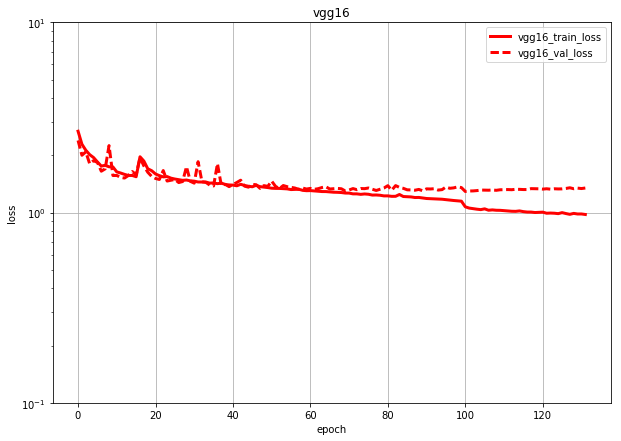

In [4]:
plt.figure(figsize=(10, 7))
#plt.plot(simple_cnn_hist["loss"], label="3lay_train_loss", linestyle="-", linewidth=3, color="black")
#plt.plot(simple_cnn_hist["val_loss"], label="3lay_val_loss", linestyle="--", linewidth=3, color="black")
plt.plot(vgg16_hist["loss"], label="vgg16_train_loss", linestyle="-", linewidth=3, color="red")
plt.plot(vgg16_hist["val_loss"], label="vgg16_val_loss", linestyle="--", linewidth=3, color="red")
plt.title("vgg16")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim((0.1, 10))
plt.yscale("log")
plt.legend(loc="best")
plt.grid()
plt.show()

## Prediction

In [5]:
from keras.preprocessing import image
import numpy as np


"""    
test_src_dir = "./processed/test"
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_src_dir,
                                                 target_size=(img_width, img_height),
                                                 class_mode=None,
                                                 batch_size=32,
                                                 shuffle=False)


# 3 layers CNN
#result = simple_cnn_model.predict_generator(generator=test_generator, val_samples=1)
result_class = simple_cnn_model.predict_classes(test_generator, verbose=2)
"""


test_src_dir = "./data/test"
filelist = os.listdir(test_src_dir)
file_count = len(filelist)
class_dict = {i: class_name for i, class_name in enumerate(os.listdir(train_subclass_dir))}

def prediction(model, batch_size):
    
    filepath = [os.path.join(test_src_dir, x) for x in filelist]
    idx = [x.split(".")[0] for x in filelist]

    img = (image.load_img(x, target_size=(img_width, img_height)) for x in filepath) # Generator 
    input_arr = [image.img_to_array(x) for x in img]
    input_arr = np.array(input_arr)
    input_arr = input_arr / 255.0  # Rescale to match training data

    pred_proba = model.predict(input_arr, batch_size=batch_size)
    pred_label = [np.argmax(x) for x in pred_proba]

    result = pd.DataFrame({"id": idx, "label": pred_label})
    
    result["label"] = result["label"].map(lambda x: class_dict[x])
    result["id"] = result["id"].astype(int)
    result.sort_values("id", inplace=True)
    
    return result


    
    
if not os.path.exists("./output"):
    os.mkdir("./output")

In [6]:
#3 layers CNN model
#simple_cnn_result = prediction(simple_cnn_model, 5000)
#simple_cnn_result.to_csv("./output/simple_cnn_result.csv", index=False)

In [7]:
#VGG16 
#vgg16_result = prediction(vgg16_like_model, 5000)
#vgg16_result.to_csv("./output/vgg16_like_result.csv", index=False)